# TSP - DFJ Recursive Subtour Elimination

$$
\begin{align}
    \text{min} \quad & \sum_{i, j \in A}d_{i, j} x_{i, j} \\
    \text{s.t.} \quad & \sum_{j \in V} x_{i, j} = \sum_{j \in V} x_{j, i} = 1 & \forall ~ i \in V\\
    & 1 \leq \sum_{i \in S} \sum_{j \in V \setminus S} x_{i, j} & \forall ~ S \subseteq V: |S| \leq |V| / 2\\
    & x_{i, j} \in \left \{ 0, 1 \right \} & \forall ~ i, j \in A\\
\end{align}
$$

In [1]:
import time

import numpy as np
from scipy.spatial.distance import pdist, squareform
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt

## Create instance

In [2]:
N = 100  # Number of points
np.random.seed(12)
coordinates = np.random.random((N, 2))
D = squareform(pdist(coordinates))

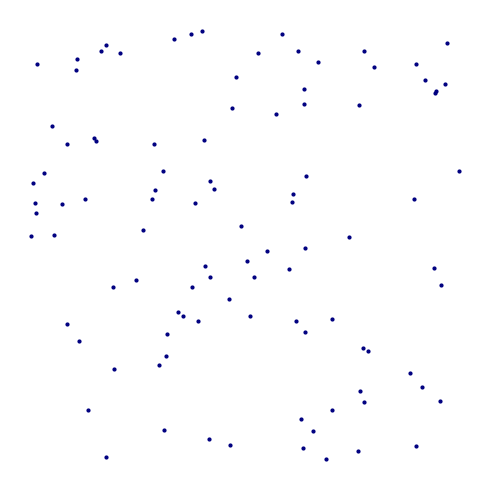

In [5]:
fig, ax = plt.subplots(figsize=[5, 5], dpi=100)

ax.scatter(coordinates[:, 0], coordinates[:, 1], color="navy", s=4)
ax.axis('off')

fig.tight_layout()
plt.show()

## pyomo model

In [7]:
# Initialize ConcreteModel
model = pyo.ConcreteModel()

In [8]:
# Sets nodes and arcs
model.V = pyo.Set(initialize=range(N))
model.A = pyo.Set(
    initialize=[(i,j) for i in range(N) 
                for j in range(N) 
                if i!=j]
)

In [9]:
# Parameter pairwise distances
model.d = pyo.Param(model.A, initialize={(i,j): D[i, j] for (i,j) in model.A})

In [10]:
# Variables
model.x = pyo.Var(model.A, within=pyo.Binary)

In [11]:
# Constraints
def arcs_in(model, i):
    return sum(model.x[:,i]) == 1


def arcs_out(model, i):
    return sum(model.x[i,:]) == 1


def subtour_elimination(model, S, Sout):
#     # Consider S is a set with values corresponding to node indexes
#     # Sout is the complementary set of elements in V but not in S
    nodes_out = sum(model.x[i,j] for i in S for j in Sout)
    return nodes_out >= 1


model.arcs_in = pyo.Constraint(model.V, rule=arcs_in)
model.arcs_out = pyo.Constraint(model.V, rule=arcs_out)
model.subtour_elimination = pyo.ConstraintList()

In [12]:
# Objective
def obj(model):
    return sum(model.d[i,j] * model.x[i,j] for i,j in model.A)


model.obj = pyo.Objective(rule=obj, sense=pyo.minimize)

### Recursive elimination strategy

In [13]:
# Find final solution (same for MTZ)
def find_tour(model):
    Q = [v for v in model.V]
    node = Q.pop(0)
    tour = [node]
    while len(Q) > 0:
        for other in Q:
            if np.isclose(model.x[node, other].value, 1, atol=1e-1):
                Q.remove(other)
                node = other
                tour.append(node)
    tour.append(tour[0])
    return tour

In [14]:
# Find all arcs active in a current solution
def find_arcs(model):
    arcs = []
    for i, j in model.A:
        if np.isclose(model.x[i, j].value, 1, atol=1e-1):
            arcs.append((i, j))
    return arcs


# Find subtours based on current arcs
def find_subtours(arcs):
    G = nx.DiGraph(arcs)
    subtours = list(nx.strongly_connected_components(G))
    return subtours


# Eliminate all subtours
def eliminate_subtours(model, subtours):
    proceed = False
    for S in subtours:
        if len(S) <= len(model.V) // 2:
            proceed = True
            Sout = {i for i in model.V if i not in S}
            model.subtour_elimination.add(subtour_elimination(model, S, Sout))
    return proceed


# Solve step
def _solve_step(model, solver, verbose=True):
    sol = solver.solve(model)
    arcs = find_arcs(model)
    subtours = find_subtours(arcs)
    if verbose:
        print(f"Current subtours: {len(subtours)}")
    time.sleep(0.1)
    proceed = eliminate_subtours(model, subtours)
    return sol, proceed


# Solve MIP using recursive elimination strategy
def solve_mip(model, solver, verbose=False):
    proceed = True
    while proceed:
        sol, proceed = _solve_step(model, solver, verbose=verbose)
    tour = find_tour(model)
    return tour

## Solve

In [15]:
solver = pyo.SolverFactory("appsi_highs")
solution = solve_mip(model, solver, verbose=True)

Current subtours: 46
Current subtours: 25
Current subtours: 10
Current subtours: 6
Current subtours: 7
Current subtours: 1


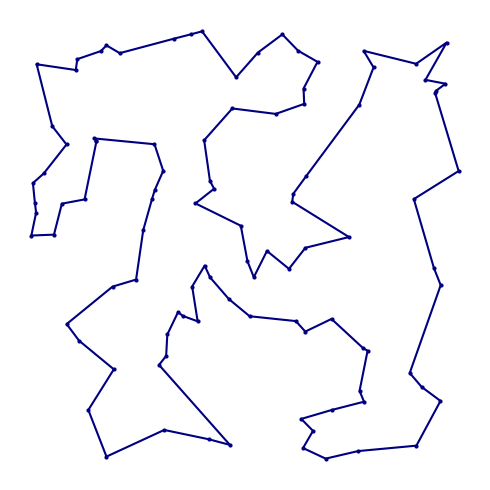

In [16]:
fig, ax = plt.subplots(figsize=[5, 5], dpi=100)

tour = np.array(solution)
ax.scatter(coordinates[tour, 0], coordinates[tour, 1], color="navy", s=4)
ax.plot(coordinates[tour, 0], coordinates[tour, 1], color="navy")
ax.axis('off')

fig.tight_layout()
plt.show()